In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from scipy.stats import ttest_ind, mannwhitneyu

Import the heights, weights and ages of major league baseball players from https://web.archive.org/web/20220629205951/https://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights.

In [2]:
# URL of the website containing the table
url = "https://web.archive.org/web/20220629205951/https://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights"

# Send a GET request to fetch the webpage"s HTML content
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Find the table using its tag and any identifying attributes
table = soup.find("table", {"class": "wikitable"})

# Extract table data into a list of rows
table_rows = table.find_all("tr")

# Initialize lists to store rows and column names
rows = []
column_names = []

# Extract table data into rows list
for row in table_rows:
    cells = row.find_all(["th", "td"])
    row_data = [cell.text.strip() for cell in cells]
    if not column_names:
        column_names = row_data  # Store column names from the first row
    else:
        rows.append(row_data)

# Convert rows list into a list of dictionaries
data = [dict(zip(column_names, row)) for row in rows]

In [3]:
# Data types mapping for each column
dtype_mapping = {
    "Name": str,
    "Team": str,
    "Position": str,
    "Height(inches)": float,
    "Weight(pounds)": float,
    "Age": float
}

# Create a DataFrame from the list of dictionaries with specified data types
df = pd.DataFrame(data)

# Clean data: Replace empty strings with 0
df.replace("", 0, inplace=True)

# Convert columns to specified data types
for col, dtype in dtype_mapping.items():
    df[col] = df[col].astype(dtype)

# Clean data: Replace 0 values with column mean
df["Weight(pounds)"]=df["Weight(pounds)"].replace(0, df["Weight(pounds)"].mean())

# Rename columns for convenience
name_mapping = {
    "Name": "name",
    "Team": "team",
    "Position": "position",
    "Height(inches)": "height",
    "Weight(pounds)": "weight",
    "Age": "age"
}

df = df.rename(columns=name_mapping)

In [4]:
# Show summary statistics
df.describe()

,height,weight,age
count,1034.000000,1034.000000,1034.000000
mean,73.697292,201.689066,28.736712
std,2.305818,20.981329,4.320310
min,67.000000,150.000000,20.900000
25%,72.000000,187.000000,25.440000
50%,74.000000,200.000000,27.925000
75%,75.000000,215.000000,31.232500
max,83.000000,290.000000,48.520000


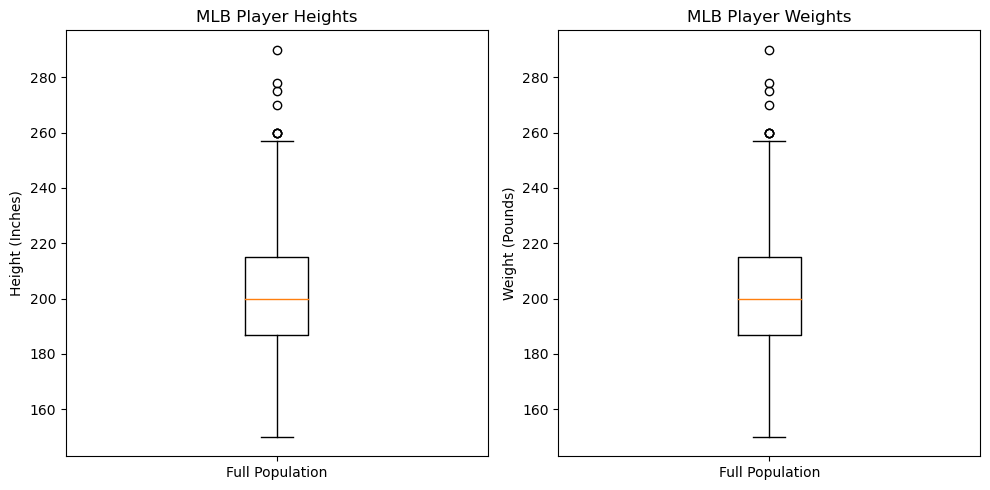

In [5]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create boxplots for height and weight
ax1.boxplot([df["weight"]])
ax1.set_ylabel("Height (Inches)")
ax1.set_title("MLB Player Heights")
ax1.set_xticks([1])
ax1.set_xticklabels(["Full Population"])

ax2.boxplot([df["weight"]])
ax2.set_ylabel("Weight (Pounds)")
ax2.set_title("MLB Player Weights")
ax2.set_xticks([1])
ax2.set_xticklabels(["Full Population"])

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

Whiskers are a maximum distance of 1.5 times the interquartile range from the upper or lower quartiles.

#### Random Samples



In [6]:
sample1 = df.sample(n=30,random_state=8675309)

sample2 = df.sample(n=30,random_state=1729)

sample3 = [71, 72, 73, 74, 74, 76, 75, 75, 75, 76, 75, 77, 76, 75, 77, 76, 75, 76, 76, 75, 75, 81,77, 75, 77, 75, 77, 77, 75, 75]

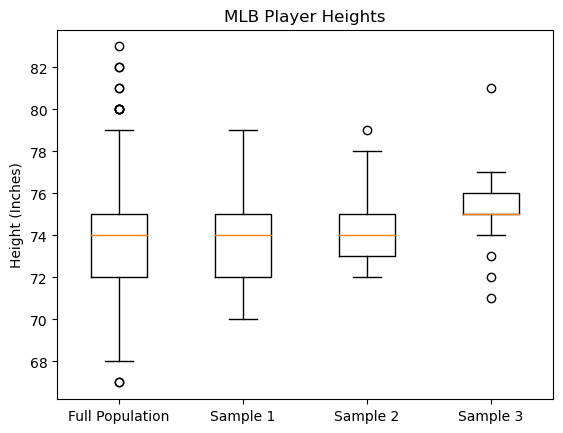

In [7]:
# Plot the heights of two random samples and a third mystery sample
fig1, ax1 = plt.subplots()
ax1.boxplot([df["height"],sample1["height"],sample2["height"],np.array(sample3)])
ax1.set_ylabel("Height (Inches)")
plt.title("MLB Player Heights")
plt.xticks([1,2,3,4], ["Full Population","Sample 1","Sample 2","Sample 3"])
plt.show()

In [8]:
# What are the means of the three populations?
print(np.mean(sample1["height"]))
print(np.mean(sample2["height"]))
print(np.mean(sample3))

73.8
74.36666666666666
75.43333333333334


Do we believe that sample3 is a random sample from the same population as sample1 and sample2?

Wen eeed to know what size differences we should expect between 1000 pairs of random samples from the population.

In [9]:
# Get a collection of 1000 sample pair means and their differences:
alldifferences = []
for i in range(1000):
    newsample1 = df.sample(n=30, random_state=i*2)
    newsample2 = df.sample(n=30, random_state=i*2 + 1)
    alldifferences.append(newsample1["height"].mean() - newsample2["height"].mean())

print(alldifferences[0:10])

[0.8333333333333286, -0.30000000000001137, -0.10000000000000853, -0.1666666666666572, 0.06666666666667709, -0.9666666666666686, 0.7999999999999972, 0.9333333333333371, -0.5333333333333314, -0.20000000000000284]


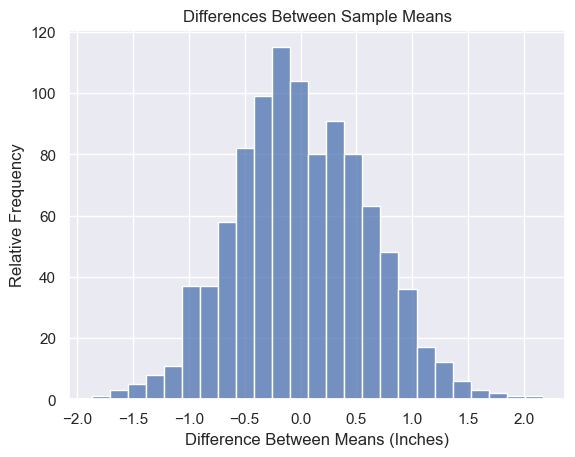

In [10]:
# Draw the histogram of differences between means
sns.set()
ax = sns.histplot(alldifferences).set_title("Differences Between Sample Means")
plt.xlabel("Difference Between Means (Inches)")
plt.ylabel("Relative Frequency")
plt.show()

In [11]:
# Difference between means of sample1 and sample3
print(np.mean(sample1["height"]) - np.mean(sample3))

-1.63333333333334


Given the low frequency of differences of this size, it seems improbable that sample3 was drawn from the same population.

We can do a t-test for independent samples and compute the p-value:

In [12]:
# Perform a two-sample t-test for independent samples
t_statistic, p_value = ttest_ind(sample1["height"], sample3)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -3.108694797644094
P-value: 0.002910554741439718


With a p-value < 0.05, we reject the null hypothesis that sample3 came from the same population as sample1.

Compare this to the t-test between sample1 and sample2:

In [13]:
# Perform a two-sample t-test
t_statistic, p_value = ttest_ind(sample1["height"], sample2["height"])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -1.0839563860213952
P-value: 0.2828695892305152


We accept (until new evidence convinces us otherwise) that the sample1 and sample2 came from the sample population.

We would use `ttest_rel` instead if the observations in different samples have a meaningful relationship to each other, e.g. if they’re two different exam scores for the same student, or two different medical test results for the same patient.

The t-test is a _parameteric_ test and rests on the following assumptions:

- sample means are normally distributed

- sample variances should be identical (if they're not, we use _Welch's t-test_ by specifying `equal_var=False`)

If we don't want to make these assumptions, we can use _nonparametric tests_ such as the _Mann-Whitney U test_:

In [14]:
# Perform mannwhitneyu between sample1 and sample2
mannwhitneyu(sample1["height"], sample2["height"])

MannwhitneyuResult(statistic=392.0, pvalue=0.38913738408151577)

#### Comparing Groups in a Practical Context

We read in two mailing lists, one for desktop computer subscribers, the other for laptop computer subscribers:

In [16]:
desktop = pd.read_csv("https://bradfordtuckfield.com/desktop.csv")
laptop = pd.read_csv("https://bradfordtuckfield.com/laptop.csv")